First, generate a random model

In [1]:
import numpy as np
import pylab as plt
from bioscrape.simulator import *
from bioscrape.types import *
import warnings


#Parameter ranges to randomly choose parameters (on a log scale)
param_min = -2
param_max = 2

#Names of different supported propensities
propensity_types = ['massaction', 'hillpositive', 'proportionalhillpositive', 'hillnegative', 'proportionalhillnegative', 'massaction']#, 'general']

#parameter names required for each propensity (general will be treated by itself)
propensity_param_requirements = {
	'massaction':['k'], 'hillpositive':['k', 'K', 'n'], 'hillnegative':['k', 'K', 'n'],
	'proportionalhillpositive':["k", "K", "n"], 'proportionalhillnegative':["k", "K", "n"]
}
#species (passed in as parameters) requires for each propensity (general will be treated by itself)
propensity_specie_requirements = {
	'hillpositive':['s1'], 'hillnegative':['s1'], 'proportionalhillpositive':['s1', 'd'], 'proportionalhillnegative':['s1', 'd'], "massaction":[]
}


species = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
n_species = len(species)
n_reactions = np.random.randint(1, 3)

reactions = []
for r in range(n_reactions):

    try_again = True
    while try_again:#Loop ensures no positive feedback which leads to long simulations
        inputs = []
        outputs = []
        while(len(inputs) == 0 and len(outputs) == 0):

            n_inputs = np.random.randint(0, 5)
            for i in range(n_inputs):
                inputs.append(species[np.random.randint(0, len(species))])

            n_outputs = np.random.randint(0, 5)
            for i in range(n_outputs):
                outputs.append(species[np.random.randint(0, len(species))])

        inputs_in_outputs = len([i for i in inputs if i in outputs])
        if inputs_in_outputs >= len(inputs):
            try_again = True
        else:
            try_again = False

    prop_type = propensity_types[np.random.randint(0, len(propensity_types))]
    param_dict = {}
    if prop_type != 'general':
        required_params = propensity_param_requirements[prop_type]
        required_species = propensity_specie_requirements[prop_type]
        param_dict = {}
        for p in required_params:
            param_dict[p] = round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3)
        for i in range(len(required_species)):
            k = required_species[i]
            param_dict[k] = species[np.random.randint(0, len(species))]

    elif prop_type == 'general': #Here we will use a random(ish) rational function
        rate_str = "(1+"
        numerator_terms = np.random.randint(0, 5)
        denominator_terms = np.random.randint(0, 5)
        for i in range(numerator_terms):
            coef = str(round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3))
            exp = str(round(np.random.uniform(low = 0, high = param_max), 3))
            specie = species[np.random.randint(0, len(species))]
            rate_str += coef+"*"+specie+"^"+exp+"+"
        rate_str =  rate_str[:-1] + ")"
        rate_str += "/(1+"
        for i in range(denominator_terms):
            coef =str(round(np.exp(np.random.uniform(low = param_min, high = param_max)), 3))
            exp = str(round(np.random.uniform(low = 0, high = param_max), 3))
            specie = species[np.random.randint(0, len(species))]
            rate_str += coef+"*"+specie+"^"+exp+"+"
        rate_str =  rate_str[:-1] + ")"
        param_dict['rate'] = rate_str

    rxn = (inputs, outputs, prop_type, param_dict)
    reactions.append(rxn)


print("Bioscrape model #rxns=", len(reactions), "\nrxns=", reactions)
M = Model(reactions = reactions, initial_condition_dict = {s:np.random.randint(10, 100) for s in species})
M.write_bioscrape_xml('models/random_model.xml')
M2 = Model('models/random_model.xml')
print("Loaded Model \n", M2.get_reactions())

Bioscrape model #rxns= 2 
rxns= [(['C', 'E', 'D', 'B'], ['A', 'B', 'E', 'B'], 'proportionalhillnegative', {'k': 0.258, 'K': 1.88, 'n': 0.545, 's1': 'A', 'd': 'D'}), (['C', 'G', 'C'], ['B', 'A', 'F'], 'massaction', {'k': 0.195})]
Loaded Model 
 [(<bioscrape.types.NegativeProportionalHillPropensity object at 0x000001961E877FB0>, <bioscrape.types.NoDelay object at 0x000001961E81BEB0>, {'C': -1, 'E': 0, 'D': -1, 'B': 1, 'A': 1}, {}), (<bioscrape.types.MassActionPropensity object at 0x000001961E85ED50>, <bioscrape.types.NoDelay object at 0x000001961E81BF30>, {'C': -2, 'G': -1, 'B': 1, 'A': 1, 'F': 1}, {})]


first simulation successful
second simulation successful


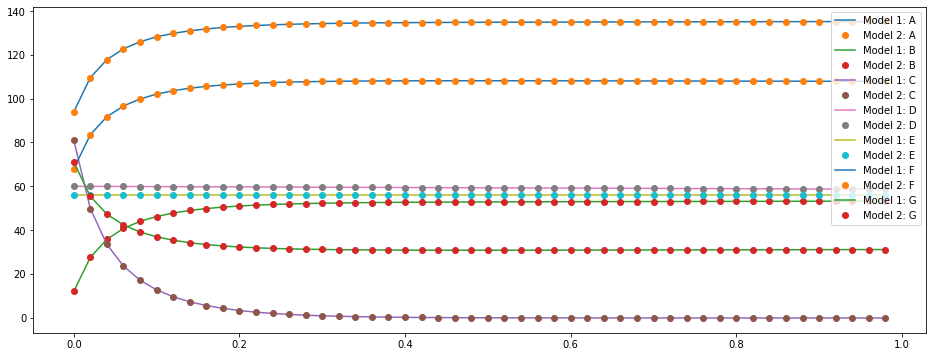

In [2]:
timepoints = np.arange(0, 1., .02)
results_1 = py_simulate_model(timepoints, Model = M, stochastic = False, safe = False)
print("first simulation successful")

results_2 = py_simulate_model(timepoints, Model = M2, stochastic = False, safe = False)
print("second simulation successful")

plt.figure(figsize = (16, 6))
for s in species:
    plt.plot(timepoints, results_1[s], "-", label = "Model 1: "+s)
    plt.plot(timepoints, results_2[s], "o", label = "Model 2: "+s)
plt.legend()
plt.show()
    

### Load an advanced SBML model (with local parameters, assignment and rate rules, and function definitions?)

In [3]:
from bioscrape.types import *
from bioscrape.sbmlutil import import_sbml

In [4]:
M = import_sbml('models/GFP.xml')

C:\ProgramData\Anaconda3\lib\site-packages\bioscrape\sbmlutil.py:88: UserWarning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations.
  'Please check rate expressions and ensure they are non-negative before doing '+
C:\ProgramData\Anaconda3\lib\site-packages\bioscrape\sbmlutil.py:184: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


In [5]:
from bioscrape.simulator import py_simulate_model
timepoints = np.linspace(0,10000,100)

results = py_simulate_model(timepoints, Model = M)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Uninitialized Model Passed into ModelCSimInterface. Model.initialize() called automatically.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
odeint failed with mxstep=500...

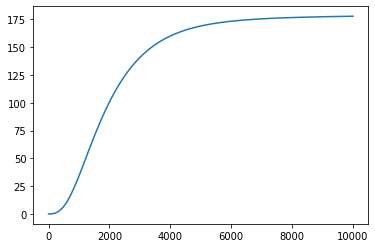

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.plot(timepoints, results["mw6600ba7f_5b6d_4e5d_89a2_4d798f44476d"])